In [16]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [17]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares--, 
        --kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '27'
"""

data = bqh.get_bigquery_data(query)

Root Mean Squared Error (RMSE): 16020070.410562651


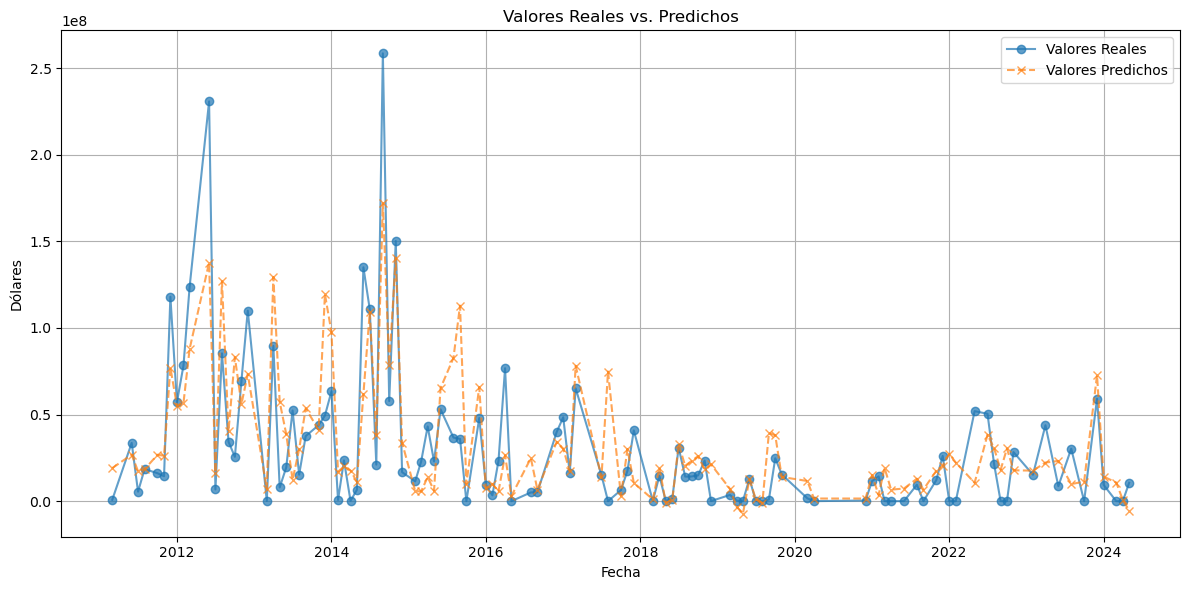

In [20]:
df = data.copy()

df = pd.DataFrame(data)


label_encoders = {}
for col in ['cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[['anio', 'mes', 'cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']]
y = df['dolares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


results = pd.DataFrame({
    'fecha': df.iloc[X_test.index]['fecha'].values,
    'dolares_real': y_test.values,
    'dolares_pred': y_pred
}).reset_index(drop=True)

results['fecha'] = pd.to_datetime(results['fecha'])

results_grouped = results.groupby('fecha').sum().reset_index()
results_grouped = results_grouped[results_grouped["fecha"] > pd.to_datetime("2010-12-31")]

#results_grouped['dolares_real'] /= 1e6
#results_grouped['dolares_pred'] /= 1e6

plt.figure(figsize=(12, 6))
plt.plot(results_grouped['fecha'], results_grouped['dolares_real'], label='Valores Reales', marker='o', linestyle='-', alpha=0.7)
plt.plot(results_grouped['fecha'], results_grouped['dolares_pred'], label='Valores Predichos', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Dólares')
plt.title('Valores Reales vs. Predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()